In [1]:
import missingno as msno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer,MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from numpy import argmax
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, classification_report



df = pd.read_csv(r"heart_cleaned.csv")
df.drop(columns = ['id','dataset'],inplace = True)

In [2]:
df.drop(columns = ['thal','ca'],inplace = True)

In [3]:
X = df.drop(columns='num', axis = 1)  # or whatever your label is
y = df['num']
X_train , X_test , y_train , y_test = train_test_split(X,y , test_size = 0.2 , random_state = 42)
X_train.describe()

,age,trestbps,chol,thalch,oldpeak
count,736.000000,690.000000,572.00000,694.000000,691.000000
mean,53.679348,131.876812,245.18153,137.456023,0.881783
std,9.226723,18.575407,55.32067,25.834490,1.065538
min,28.000000,92.000000,109.87500,75.560000,-0.586000
25%,47.000000,120.000000,209.00000,120.000000,0.000000
50%,54.000000,130.000000,237.00000,140.000000,0.500000
75%,60.000000,140.000000,274.25000,158.000000,1.500000
max,77.000000,200.000000,451.03000,202.000000,4.000000


In [4]:



cp_order = [['typical angina', 'atypical angina', 'non-anginal', 'asymptomatic']]
slope_order = [['upsloping', 'flat', 'downsloping']]
restecg_order = [['normal', 'st-t abnormality', 'lv hypertrophy']]
scale_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']


#Pipeline for categorical columns
sex_pipeline = Pipeline([
    ("encode", OrdinalEncoder(categories=[["Female","Male"]], handle_unknown="use_encoded_value", unknown_value=np.nan))
])

exang_pipeline = Pipeline([
     ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OrdinalEncoder(categories=[[False,True]], handle_unknown="use_encoded_value", unknown_value=np.nan))
])

fbs_pipeline= Pipeline([
     ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OrdinalEncoder(categories=[[False,True]], handle_unknown="use_encoded_value", unknown_value=np.nan))
])

restecg_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OrdinalEncoder(categories=restecg_order, handle_unknown="use_encoded_value", unknown_value=np.nan))
])

cp_pipeline = Pipeline([
    ("encode", OrdinalEncoder(categories=cp_order, handle_unknown="use_encoded_value", unknown_value=np.nan))
])

slope_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OrdinalEncoder(categories=slope_order, handle_unknown="use_encoded_value", unknown_value=np.nan))
])

num_scale_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# Final ColumnTransformer
cat_preprocessor = ColumnTransformer(transformers=[
    ("restecg", restecg_pipeline, ['restecg']),
    ("cp", cp_pipeline, ['cp']),
    ("slope", slope_pipeline, ['slope']),
    ("sex",sex_pipeline,['sex']),
    ("fbs",fbs_pipeline,["fbs"]),
    ("exang",exang_pipeline,["exang"])
], remainder='passthrough', verbose_feature_names_out=False)

# Columns
knn_cols = ['trestbps', 'thalch', 'oldpeak']
chol_cols =  ['chol','sex','fbs','thalch','age','cp','restecg'] #['chol','age' , 'sex' , 'fbs', 'thalch', 'age','cp','restecg']

# Pipelines
knn_pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5))
])

chol_pipeline = Pipeline([
    ("imputer", IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10, random_state=0),
        max_iter=10,
        random_state=0))
])

chol_transformer = ColumnTransformer(transformers = [
    ('chol',chol_pipeline,chol_cols)
],remainder = "passthrough" , verbose_feature_names_out = False)


knn_transformer = ColumnTransformer(transformers=[
    ('knn', knn_pipeline, knn_cols)
], remainder='passthrough', verbose_feature_names_out=False)



cat_preprocessor.set_output(transform='pandas')
knn_transformer.set_output(transform='pandas')
chol_transformer.set_output(transform='pandas')

### STEP 4: FINAL FULL PIPELINE
full_pipeline = Pipeline([
    ("categorical", cat_preprocessor),
    ("knn", knn_transformer),
    ("chol",chol_transformer) ])


X_train_transformed =  full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)
X_train_transformed

,chol,sex,fbs,thalch,age,cp,restecg,trestbps,oldpeak,slope,exang
880,170.0000,1.0,0.0,120.000000,62.0,3.0,1.0,132.000000,3.000000,1.0,1.0
457,224.4875,1.0,0.0,122.000000,54.0,2.0,0.0,150.000000,0.000000,1.0,0.0
797,339.0000,1.0,0.0,137.456023,51.0,2.0,0.0,131.876812,0.881783,1.0,0.0
25,219.0000,0.0,0.0,158.000000,50.0,2.0,0.0,120.000000,1.600000,1.0,0.0
84,325.0000,1.0,0.0,172.000000,52.0,1.0,0.0,120.000000,0.200000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
106,177.0000,1.0,0.0,162.000000,59.0,3.0,0.0,140.000000,0.000000,0.0,1.0
270,207.0000,1.0,0.0,138.000000,61.0,3.0,2.0,140.000000,1.900000,0.0,1.0
860,310.0000,1.0,1.0,112.000000,75.0,3.0,0.0,160.000000,2.000000,2.0,1.0
435,216.0000,0.0,0.0,142.000000,53.0,1.0,0.0,140.000000,2.000000,1.0,1.0


In [5]:
order = X_train.columns
X_train_transformed = X_train_transformed[order]
X_test_transformed = X_test_transformed[order]

In [6]:
X_train_transformed.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
dtype: int64

# SVM

In [7]:
X_test_transformed

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope
319,36.0,1.0,1.0,120.0,166.000,0.0,0.0,180.0,0.0,0.0,1.0
377,45.0,1.0,1.0,140.0,224.000,1.0,0.0,122.0,0.0,0.0,1.0
538,48.0,1.0,3.0,160.0,329.000,0.0,0.0,92.0,1.0,1.5,1.0
296,59.0,1.0,3.0,164.0,176.000,1.0,2.0,90.0,0.0,1.0,1.0
531,40.0,0.0,3.0,150.0,392.000,0.0,0.0,130.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
382,46.0,1.0,1.0,140.0,275.000,0.0,0.0,165.0,1.0,0.0,1.0
97,60.0,0.0,3.0,150.0,258.000,0.0,2.0,157.0,0.0,2.6,1.0
906,61.0,1.0,2.0,120.0,337.000,0.0,0.0,98.0,1.0,0.0,1.0
467,55.0,1.0,3.0,120.0,270.000,0.0,0.0,140.0,0.0,0.0,1.0


[0.77027027 0.80272109 0.82993197 0.82312925 0.78911565]
0.8030336458907887

 Test Accuracy (using tuned threshold): 0.8478

 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        75
           1       0.86      0.88      0.87       109

    accuracy                           0.85       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



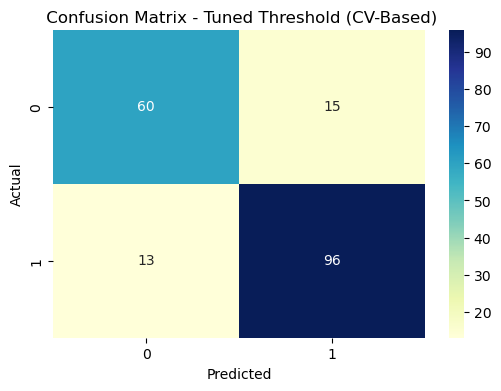

In [8]:
categorical_features = ['cp','restecg']
numerical_features = ['age','trestbps','chol','oldpeak','thalch']

# ColumnTransformer: Apply OneHot to categorical, scaling to numerical

categorical_cols = ['restecg', 'cp']
numerical_cols = ['age','trestbps','chol','oldpeak','thalch']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

svm_model =  SVC(kernel = 'rbf' ,C = 0.3990946408430501 ,gamma = 'auto' ,random_state = 42,probability=True) 
# Full pipeline
svm_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('clf', svm_model)
])

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(svm_pipeline, X_train_transformed , y_train , cv = cv , scoring='accuracy')
print(score)
print(np.mean(score))


svm_pipeline.fit(X_train_transformed, y_train)

y_pred = svm_pipeline.predict(X_test_transformed )

cm_best = confusion_matrix(y_test, y_pred)
acc_best = accuracy_score(y_test, y_pred)

print(f"\n Test Accuracy (using tuned threshold): {acc_best:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='YlGnBu')
plt.title(" Confusion Matrix - Tuned Threshold (CV-Based)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Logistic Regression


 Test Accuracy (using tuned threshold): 0.8370

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        75
           1       0.84      0.90      0.87       109

    accuracy                           0.84       184
   macro avg       0.84      0.82      0.83       184
weighted avg       0.84      0.84      0.84       184



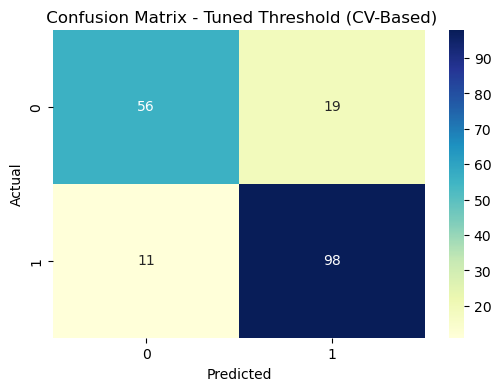

In [9]:

from sklearn.base import BaseEstimator, ClassifierMixin
class log_regression(BaseEstimator, ClassifierMixin):
    def __init__(self,max_iter ,C, solver , penalty):
        self.max_iter = max_iter
        self.C= C
        self.solver = solver
        self.penalty = penalty
        self.lg_model_ =  None


    def fit(self,X_train,y_train):
        self.lg_model_ = LogisticRegression(
            max_iter=self.max_iter,
            C=self.C,
            solver=self.solver,
            penalty=self.penalty
        )
        threshold_list = []
        accuracy_thresh = []
        # create StratifiedKFold
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for train_idx , val_idx  in cv.split(X_train,y_train):
            X_train_fold,X_val_fold = X_train.iloc[train_idx],X_train.iloc[val_idx]
            y_train_fold,y_val_fold = y_train.iloc[train_idx],y_train.iloc[val_idx]


            self.lg_model_.fit(X_train_fold , y_train_fold)
            y_probs_val =  self.lg_model_.predict_proba(X_val_fold)[:, 1]


            fpr , tpr , thresholds  = roc_curve(y_val_fold , y_probs_val)
            desired_tpr = 0.90
            for i , t in enumerate(thresholds):
                if tpr[i] >= desired_tpr:
                    threshold_list.append(thresholds[i])
                    break
            
            y_val_pred = (y_probs_val >= thresholds[i]).astype(int)
            accuracy_thresh.append(accuracy_score(y_val_pred,y_val_fold))


        self.best_threshold = np.mean(threshold_list)


        return self

    def predict(self, X):
        probs = self.lg_model_.predict_proba(X)[:, 1]
        return (probs >= self.best_threshold).astype(int)

    def predict_proba(self, X):
        return self.lg_model_.predict_proba(X)



lg_model = log_regression(max_iter = 1000 , C = 0.2 , solver =  'lbfgs' , penalty ='l2')

categorical_features = ['cp','restecg']
numerical_features = ['age','trestbps','chol','oldpeak','thalch']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output=False), categorical_features),
    ("num", StandardScaler(), numerical_cols)
] , remainder = 'passthrough',verbose_feature_names_out = False,force_int_remainder_cols=False)


log_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf',lg_model)
])
log_pipeline

preprocessor.set_output(transform= 'pandas')
log_pipeline.fit(X_train_transformed , y_train)
y_pred = log_pipeline.predict(X_test_transformed)
# Confusion Matrix and Accuracy
accuracy_score(y_pred,y_test)
cm_best = confusion_matrix(y_test, y_pred)
acc_best = accuracy_score(y_test, y_pred)

print(f"\n Test Accuracy (using tuned threshold): {acc_best:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='YlGnBu')
plt.title(" Confusion Matrix - Tuned Threshold (CV-Based)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Random Forests

In [10]:
#rf_best_params = {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
rf_best_params = {'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_leaf_nodes': 35, 'min_impurity_decrease': 0.0015710772668609695, 'n_estimators': 200}

In [11]:

rf_best_params = {'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_leaf_nodes': 35, 'min_impurity_decrease': 0.0015710772668609695, 'n_estimators': 200}
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

rf_model =  RandomForestClassifier(**rf_best_params ,n_jobs =  -1, random_state=42)

rf_pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('model', rf_model)
        ])
score = cross_val_score(rf_pipeline ,X_train_transformed , y_train , cv = cv , scoring = "accuracy")
print(score)
print(np.mean(score))
rf_pipeline.fit(X_train_transformed , y_train)
rf_pipeline.score(X_test_transformed,y_test)
y_pred = rf_pipeline.predict(X_test_transformed)

[0.76351351 0.76870748 0.82993197 0.82993197 0.78911565]
0.7962401176686891



 Random Forest Accuracy: 0.8370

 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81        75
           1       0.88      0.84      0.86       109

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.84      0.84       184



C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


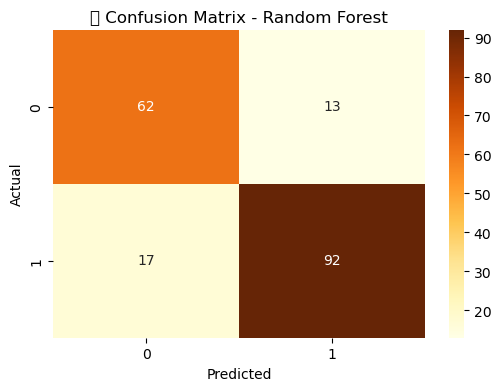

In [12]:
acc= accuracy_score(y_test , y_pred)
cr = classification_report(y_test , y_pred)
cm = confusion_matrix(y_test,y_pred)

print(f"\n Random Forest Accuracy: {acc:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.title(" Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# XBBOOST

In [13]:
xg_best_params = {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.018458243866393068, 'subsample': 0.730836966210819, 'gamma': 3.6856779411060057}


 Random Forest Accuracy: 0.8370

 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        75
           1       0.87      0.85      0.86       109

    accuracy                           0.84       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



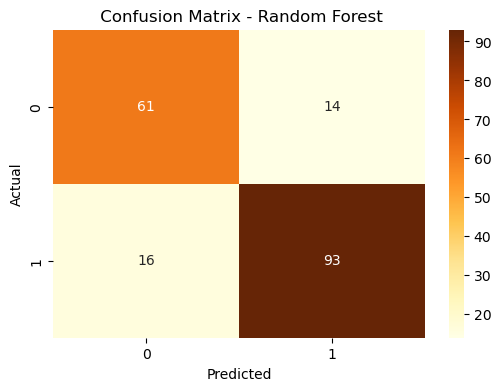

In [14]:
# Train the final model with best params from Optuna
from xgboost import XGBClassifier

xgb_model = XGBClassifier(**xg_best_params,random_state = 42)

# Build final pipeline
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', xgb_model)
])

# Fit the final model on full training data
xgb_pipeline.fit(X_train_transformed, y_train)

# Evaluate on test set
y_pred = xgb_pipeline.predict(X_test_transformed)

acc= accuracy_score(y_test , y_pred)
cr = classification_report(y_test , y_pred)
cm = confusion_matrix(y_test,y_pred)

print(f"\n Random Forest Accuracy: {acc:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.title(" Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



# Decision Tree

In [15]:
dt_best_params ={'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_leaf_nodes': 39, 'min_impurity_decrease': 0.0006509902752228316}

In [16]:
from sklearn.tree import DecisionTreeClassifier
model= DecisionTreeClassifier(random_state = 42)
cv = StratifiedKFold(n_splits = 5 , shuffle = True , random_state = 42)
score = cross_val_score(model,X_train_transformed , y_train , cv = cv , scoring = "accuracy")
print(score)
print(np.mean(score))

[0.67567568 0.68707483 0.72789116 0.63945578 0.68027211]
0.6820739106453392


In [17]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(**dt_best_params,random_state = 42)
cv = StratifiedKFold(n_splits = 5 , shuffle = True , random_state = 42)
score = cross_val_score(dt_model ,X_train_transformed , y_train , cv = cv , scoring = "accuracy")
print(score)
print(np.mean(score))

[0.72297297 0.78911565 0.78911565 0.73469388 0.76870748]
0.7609211252068395



 Test Accuracy (using tuned threshold): 0.7880

 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        75
           1       0.85      0.78      0.81       109

    accuracy                           0.79       184
   macro avg       0.78      0.79      0.78       184
weighted avg       0.79      0.79      0.79       184



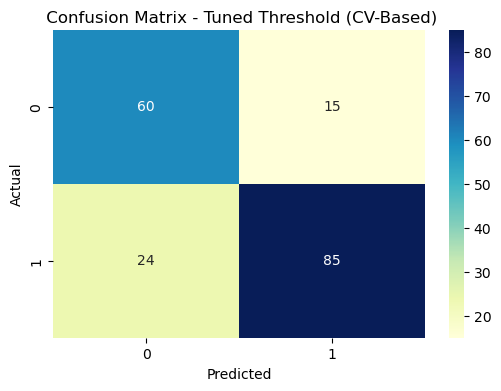

In [18]:
dt_model.fit(X_train_transformed , y_train)
y_pred = dt_model.predict(X_test_transformed)


cm_best = confusion_matrix(y_test, y_pred)
acc_best = accuracy_score(y_test, y_pred)

print(f"\n Test Accuracy (using tuned threshold): {acc_best:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='YlGnBu')
plt.title(" Confusion Matrix - Tuned Threshold (CV-Based)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
y_train.nunique()

2

# Voting Classifier

In [20]:
from sklearn.ensemble import VotingClassifier

In [21]:
categorical_cols = ['restecg', 'cp']
numerical_cols = ['age','trestbps','chol','oldpeak','thalch']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
   ('cat', OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output=False), categorical_features)
], remainder='passthrough')



In [22]:
from scipy.stats import mode
import numpy as np

def voting(pipeline_dict, X_train, y_train, X_test):

    model_preds = []
    for name, pipeline in pipeline_dict.items():
        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_test)
        model_preds.append(preds)


     # Majority voting along axis 0 → returns (n_samples,)
    y_pred, _ = mode(model_preds, axis=0)     
    return y_pred
    
pipeline_dict = {
    'xgb': xgb_pipeline,
    'rf': rf_pipeline,
    'svm': svm_pipeline,
    'logreg': log_pipeline
}

y_pred = voting(pipeline_dict, X_train_transformed, y_train, X_test_transformed)

print("Hard Voting Accuracy:", accuracy_score(y_test, y_pred))


Hard Voting Accuracy: 0.8478260869565217



 Test Accuracy (using tuned threshold): 0.8478

 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        75
           1       0.88      0.86      0.87       109

    accuracy                           0.85       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



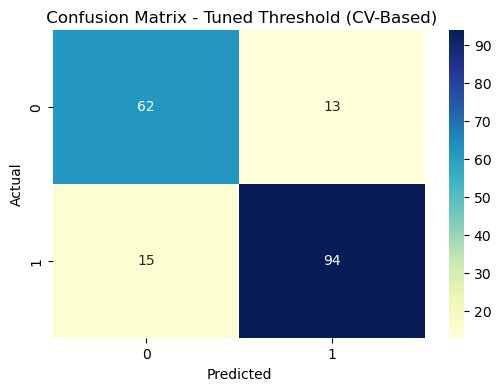

In [23]:
cm_best = confusion_matrix(y_test, y_pred)
acc_best = accuracy_score(y_test, y_pred)

print(f"\n Test Accuracy (using tuned threshold): {acc_best:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='YlGnBu')
plt.title(" Confusion Matrix - Tuned Threshold (CV-Based)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
import pickle

In [25]:
# Step 1: Define class
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
import numpy as np

class HardVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, pipeline_dict):
        self.pipeline_dict = pipeline_dict
        self.fitted_pipelines = {}

    def fit(self, X, y):
        self.fitted_pipelines = {}
        for name, pipeline in self.pipeline_dict.items():
            self.fitted_pipelines[name] = pipeline.fit(X, y)
        return self

    def predict(self, X):
        model_preds = []
        for name, pipeline in self.fitted_pipelines.items():
            preds = pipeline.predict(X)
            model_preds.append(preds)

        y_pred, _ = mode(model_preds, axis=0)
        return y_pred.ravel()



# Step 2: Create, train, and save the model
voting_model = HardVotingClassifier(pipeline_dict)
voting_model.fit(X_train_transformed, y_train)
y_pred = voting_model.predict(X_test_transformed)
print("Hard Voting Accuracy:", accuracy_score(y_test, y_pred))


with open("voting_model.pkl", "wb") as f:
    pickle.dump(voting_model, f)


Hard Voting Accuracy: 0.8478260869565217


In [26]:
with open('df.pkl', 'wb') as file:
    pickle.dump(X, file)

In [27]:
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(full_pipeline, file)

In [28]:
import os
os.getcwd()


'C:\\Users\\saini'

In [29]:
X_train_transformed

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope
880,62.0,1.0,3.0,132.000000,170.0000,0.0,1.0,120.000000,1.0,3.000000,1.0
457,54.0,1.0,2.0,150.000000,224.4875,0.0,0.0,122.000000,0.0,0.000000,1.0
797,51.0,1.0,2.0,131.876812,339.0000,0.0,0.0,137.456023,0.0,0.881783,1.0
25,50.0,0.0,2.0,120.000000,219.0000,0.0,0.0,158.000000,0.0,1.600000,1.0
84,52.0,1.0,1.0,120.000000,325.0000,0.0,0.0,172.000000,0.0,0.200000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
106,59.0,1.0,3.0,140.000000,177.0000,0.0,0.0,162.000000,1.0,0.000000,0.0
270,61.0,1.0,3.0,140.000000,207.0000,0.0,2.0,138.000000,1.0,1.900000,0.0
860,75.0,1.0,3.0,160.000000,310.0000,1.0,0.0,112.000000,1.0,2.000000,2.0
435,53.0,0.0,1.0,140.000000,216.0000,0.0,0.0,142.000000,1.0,2.000000,1.0


In [30]:
X_test_transformed

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope
319,36.0,1.0,1.0,120.0,166.000,0.0,0.0,180.0,0.0,0.0,1.0
377,45.0,1.0,1.0,140.0,224.000,1.0,0.0,122.0,0.0,0.0,1.0
538,48.0,1.0,3.0,160.0,329.000,0.0,0.0,92.0,1.0,1.5,1.0
296,59.0,1.0,3.0,164.0,176.000,1.0,2.0,90.0,0.0,1.0,1.0
531,40.0,0.0,3.0,150.0,392.000,0.0,0.0,130.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
382,46.0,1.0,1.0,140.0,275.000,0.0,0.0,165.0,1.0,0.0,1.0
97,60.0,0.0,3.0,150.0,258.000,0.0,2.0,157.0,0.0,2.6,1.0
906,61.0,1.0,2.0,120.0,337.000,0.0,0.0,98.0,1.0,0.0,1.0
467,55.0,1.0,3.0,120.0,270.000,0.0,0.0,140.0,0.0,0.0,1.0


In [31]:
X_test

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope
319,36,Male,atypical angina,120.0,166.0,False,normal,180.0,False,0.0,NaN
377,45,Male,atypical angina,140.0,224.0,True,normal,122.0,False,0.0,NaN
538,48,Male,asymptomatic,160.0,329.0,False,normal,92.0,True,1.5,flat
296,59,Male,asymptomatic,164.0,176.0,True,lv hypertrophy,90.0,False,1.0,flat
531,40,Female,asymptomatic,150.0,392.0,False,normal,130.0,False,2.0,flat
...,...,...,...,...,...,...,...,...,...,...,...
382,46,Male,atypical angina,140.0,275.0,False,normal,165.0,True,0.0,NaN
97,60,Female,asymptomatic,150.0,258.0,False,lv hypertrophy,157.0,False,2.6,flat
906,61,Male,non-anginal,120.0,337.0,False,normal,98.0,True,0.0,NaN
467,55,Male,asymptomatic,120.0,270.0,False,normal,140.0,False,0.0,NaN


In [32]:
test_data = pd.DataFrame({
    'age': [58],
    'sex': ['male'],
    'cp': ['typical angina'],
    'trestbps': [130],
    'chol': [230],
    'fbs': [False],
    'restecg': ['normal'],
    'thalch': [150],
    'exang': [False],
    'oldpeak': [1.5],
    'slope': ['upsloping']
})


In [33]:
y_test 

319    0
377    0
538    1
296    1
531    1
      ..
382    0
97     1
906    1
467    0
732    1
Name: num, Length: 184, dtype: int64

In [34]:
test_data = full_pipeline.transform(test_data)

In [35]:
test_data = test_data[order]

In [36]:
test_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope
0,58.0,1.0,0.0,130.0,230.0,0.0,0.0,150.0,0.0,1.5,0.0


In [37]:
voting_model.predict(test_data) 

array([0], dtype=int64)